Данный скрипт анализирует наборы таблиц db1 и db2 на наличие аномалий по алгоритму кластеризации DBSCAN.
Выгрузка аномальных записей, по которым требуется оценка эксперта, осуществляется в формате .csv.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
db1__catch = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/catch.csv", parse_dates=['date'])
db1__product = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/product.csv", parse_dates=['date'])
db1__fish = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/fish.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__prod_designate = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/prod_designate.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__prod_type = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/prod_type.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__regime = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/regime.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__region = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/region.csv", encoding='utf8', on_bad_lines='skip', sep=';')

db2__ext = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db2/Ext.csv", encoding='utf8', parse_dates=['date_fishery', 'Product_period'])
db2__ext2 = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db2/Ext2.csv", encoding='utf8', parse_dates=['date_vsd'])

In [3]:
db1__catch.name = 'db1__catch'
db1__product.name = 'db1__product'
db1__fish.name = 'db1__fish'
db1__prod_designate.name = 'db1__prod_designate'
db1__prod_type.name = 'db1__prod_type'
db1__regime.name = 'db1__regime'
db1__region.name = 'db1__region'
db2__ext.name = 'db2__ext'
db2__ext2.name = 'db2__ext2'

datasets = {'db1__catch':db1__catch,
            'db1__product':db1__product,
            'db1__fish':db1__fish,
            'db1__prod_designate':db1__prod_designate,
            'db1__prod_type':db1__prod_type,
            'db1__regime':db1__regime,
            'db1__region':db1__region,
            'db2__ext':db2__ext,
            'db2__ext2':db2__ext2
            }
    
def general_information (dataset):
    
    total_na = dataset.isna().sum().sort_values(ascending = False)
    percent_of_na = (dataset.isna().sum() * 100 / dataset.isna().count()).sort_values(ascending=False)
    missing_dataset = pd.concat([total_na, percent_of_na], axis = 1, keys = ['Missing values quantity', '%_of missing values'])
    for index in missing_dataset.index:
        missing_dataset.loc[index, 'Unique values quantity'] = dataset[index].value_counts().count()
    missing_dataset['Unique values quantity'] = missing_dataset['Unique values quantity'].astype('int64')
    missing_dataset['Data type'] = dataset[missing_dataset.index].dtypes
    missing_dataset.index.name = 'Feature'

    print('\033[92m', '\033[4m', 'Dataset {} consist of {} objects and {} features'.
        format('" '+dataset.name+' "', len(dataset), len(dataset.columns)), '\033[0m', end='\n\n')

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        print(missing_dataset.to_string(), end='\n\n')

for k, v in datasets.items():
    general_information(v)

  Dataset " db1__catch " consist of 85087 objects and 8 features 

              Missing values quantity  %_of missing values  Unique values quantity       Data type
Feature                                                                                           
id_ves                              0                  0.0                     733           int64
date                                0                  0.0                     110  datetime64[ns]
id_region                           0                  0.0                      50           int64
id_fish                             0                  0.0                     118           int64
catch_volume                        0                  0.0                   30429         float64
id_regime                           0                  0.0                      10           int64
permit                              0                  0.0                    1408           int64
id_own                              0     

In [4]:
for k, v in datasets.items():

    print('The numder of duplicates in dataset """ {} """ is     {}'.format(k, v.duplicated().sum()))

The numder of duplicates in dataset """ db1__catch """ is     0
The numder of duplicates in dataset """ db1__product """ is     0
The numder of duplicates in dataset """ db1__fish """ is     0
The numder of duplicates in dataset """ db1__prod_designate """ is     0
The numder of duplicates in dataset """ db1__prod_type """ is     0
The numder of duplicates in dataset """ db1__regime """ is     0
The numder of duplicates in dataset """ db1__region """ is     0
The numder of duplicates in dataset """ db2__ext """ is     0
The numder of duplicates in dataset """ db2__ext2 """ is     0


In [5]:
db2__ext2[db2__ext2.unit.isin(['\\N'])].volume.describe()

count    6.245200e+04
mean     1.687210e+04
std      4.776406e+04
min      0.000000e+00
25%      2.170000e+02
50%      1.105000e+03
75%      8.747250e+03
max      3.905000e+06
Name: volume, dtype: float64

Переводим кг и \\N в тонны

In [6]:
db2__ext2.loc[db2__ext2.unit.isin(['кг']), 'volume'] = db2__ext2.loc[db2__ext2.unit.isin(['кг']), 'volume'] / 1000
db2__ext2.loc[db2__ext2.unit.isin(['\\N']), 'volume'] = db2__ext2.loc[db2__ext2.unit.isin(['\\N']), 'volume'] / 1000

numPart убираем (всего 0.0003% значимых значений), Name_Plat не нужен, есть id_Plat

In [119]:
db1_main = pd.merge(
pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(db1__catch, db1__product, how='outer', on=['id_ves', 'date']), db1__fish, how='left', on=['id_fish']), db1__prod_designate, how='left', on=['id_prod_designate']), \
db1__prod_type[['id_prod_type', 'prod_type_full']], how='left', on=['id_prod_type']), db1__regime, how='left', on=['id_regime']), db1__region, how='left', on=['id_region']
)


db2_main = pd.merge(db2__ext.drop(columns=['numPart', 'Name_Plat']), db2__ext2.drop(columns=['num_vsd',	'unit']), how='inner', on=['id_vsd'])
db2_main['date_delta']=(db2_main['date_vsd']-db2_main['date_fishery']).apply(lambda x: x.seconds//3600)


db1_main = db1_main.drop(columns=['id_region', 'id_fish', 'id_regime', 'permit', 'id_prod_designate', 'id_prod_type'])
db2_main = db2_main.drop(columns=['date_vsd'])

In [120]:
db2_main.shape

(3205586, 11)

Удаляем наблюдения со значением -1 в id_own, id_ves и id_fish из db2_main

In [121]:
db2_main.drop(db2_main[(db2_main.id_ves < 0) & (db2_main.id_own < 0)].index, inplace=True)
db2_main.drop(db2_main[db2_main.id_fish < 0].index, inplace=True)

In [122]:
db2_main.shape

(62452, 11)

In [123]:
db1_main.set_index('date', inplace=True)
db2_main.set_index('date_fishery', inplace=True)
db2_main.index.name ='date'
db1_main.sort_index(inplace=True)
db2_main.sort_index(inplace=True)
db2_main.rename(columns={'Region_Plat':'region'}, inplace=True)

In [124]:
def dbscan_evaluate(dataset):
    
    columns = dataset.select_dtypes(['int64', 'float64']).columns.tolist()
    columns.remove('id_ves')
    columns.remove('id_own')
    
    try:
        columns.remove('id_Plat')
    except ValueError:
        pass
    try:
        columns.remove('id_vsd')
    except ValueError:
        pass
    try:
        columns.remove('id_fish')
    except ValueError:
        pass


    scaler = StandardScaler()
    pca = PCA (n_components=3)
    for i_eps in range(11,22):
        print('DBSCAN hyperparameters: n_components = 3, eps = {}, min_samples = 3'.format(i_eps/10), end='\n\n')


        try:
            column_dict = {}

            for column in columns:
                column_dict.update({column:['mean','median','min','max','sum']})

            grouped_data = dataset.groupby(['date', 'id_ves', 'id_own', 'region']).agg(column_dict)

            X_scale = scaler.fit_transform(grouped_data)    
                        
            X_reduced = pca.fit_transform(X_scale)
            pred = DBSCAN(eps=i_eps/10, min_samples=3).fit_predict(X_reduced)
            fig = plt.figure(figsize = (21,15))
            ax = fig.add_subplot(projection="3d")
            x,y,z = [X_reduced[:,i] for i in range(3)]
            ax.scatter(x,y,z, c=pred)
            plt.show()
        except ValueError:
            column_dict = {}

            for column in columns:
                column_dict.update({column:'sum'})

            grouped_data = dataset.groupby(['date', 'id_ves', 'id_own', 'region']).agg(column_dict)

            X_scale = scaler.fit_transform(grouped_data)    
                        
            X_reduced = pca.fit_transform(X_scale)
            pred = DBSCAN(eps=i_eps/10, min_samples=3).fit_predict(X_reduced)
            fig = plt.figure(figsize = (21,15))
            ax = fig.add_subplot(projection="3d")
            x,y,z = [X_reduced[:,i] for i in range(3)]
            ax.scatter(x,y,z, c=pred)
            plt.show()

DBSCAN hyperparameters: n_components = 3, eps = 1.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


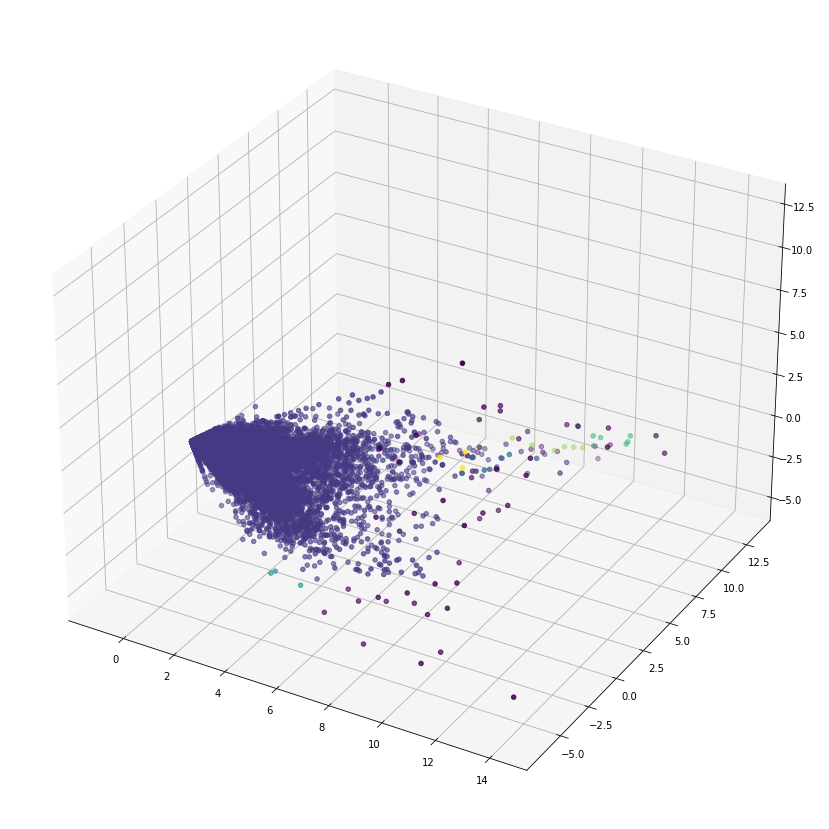

DBSCAN hyperparameters: n_components = 3, eps = 1.2, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


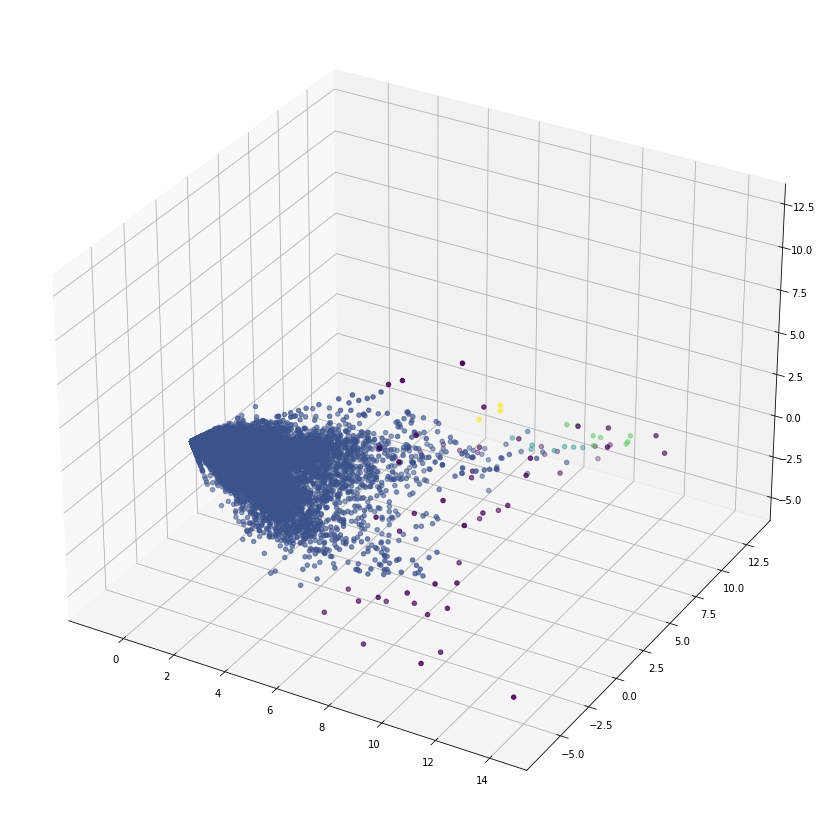

DBSCAN hyperparameters: n_components = 3, eps = 1.3, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


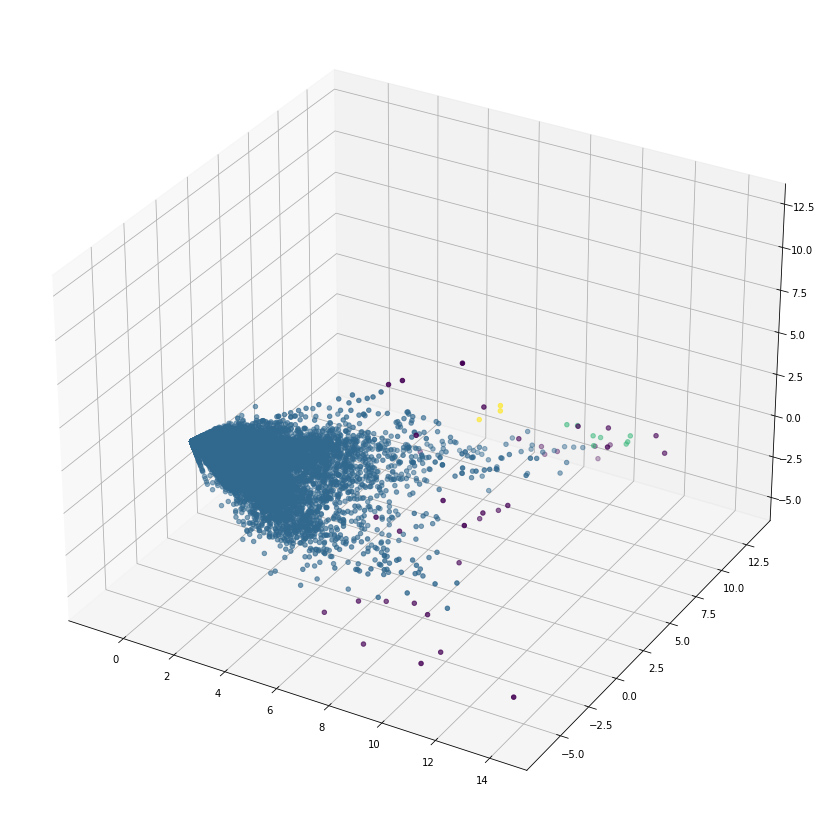

DBSCAN hyperparameters: n_components = 3, eps = 1.4, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


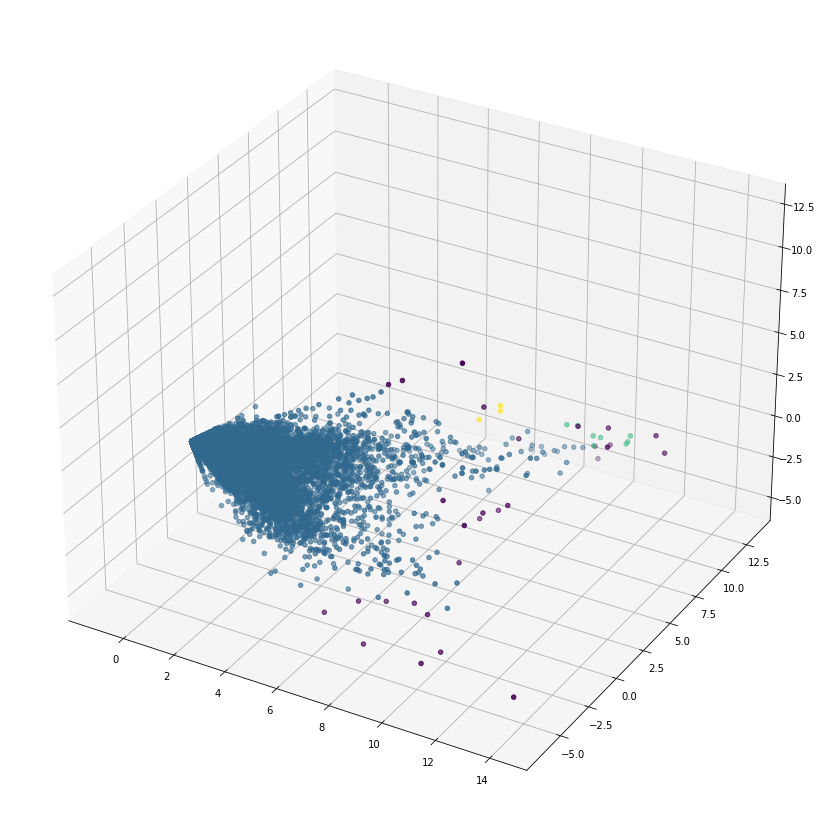

DBSCAN hyperparameters: n_components = 3, eps = 1.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


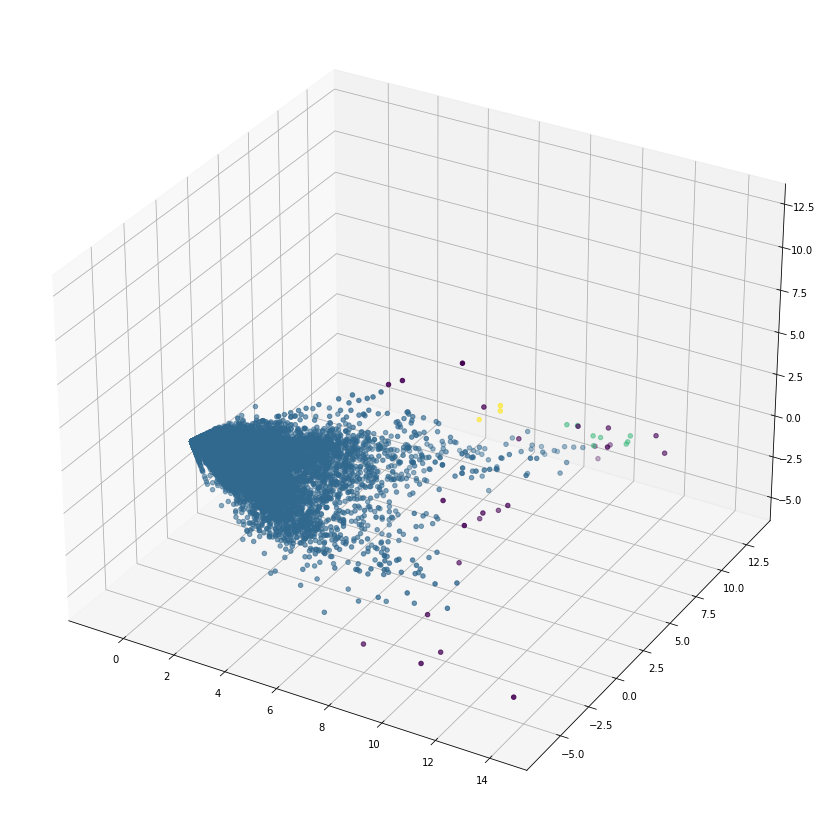

DBSCAN hyperparameters: n_components = 3, eps = 1.6, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


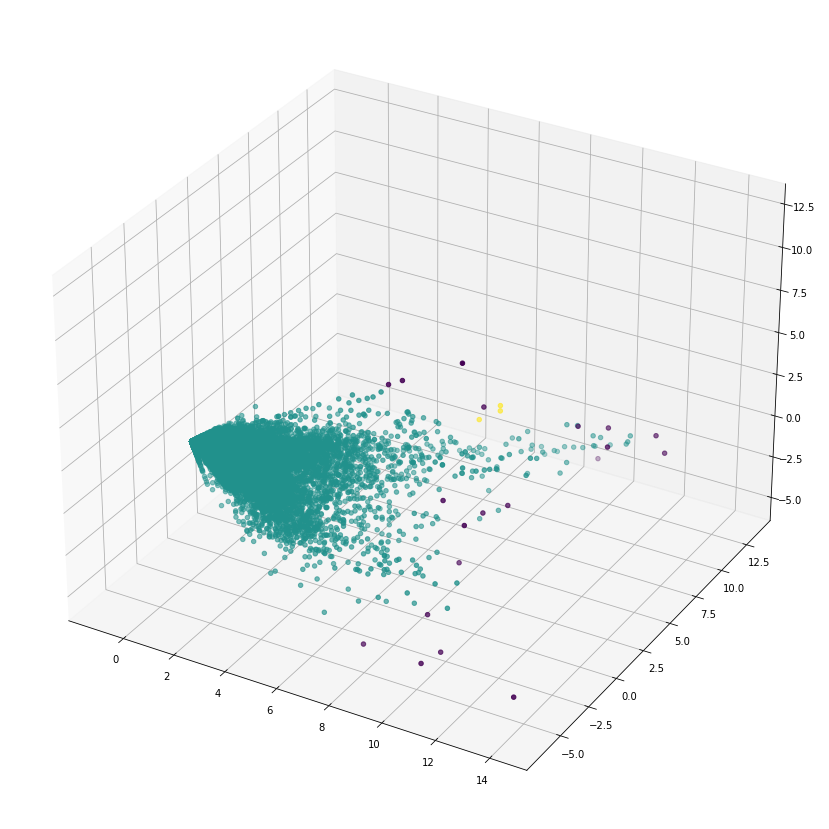

DBSCAN hyperparameters: n_components = 3, eps = 1.7, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


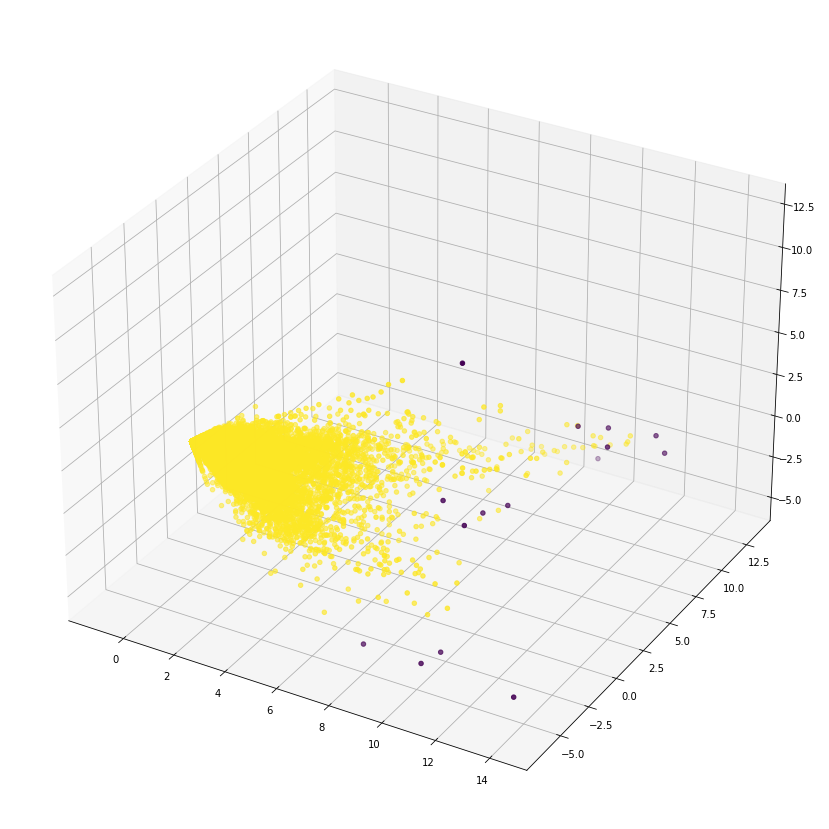

DBSCAN hyperparameters: n_components = 3, eps = 1.8, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


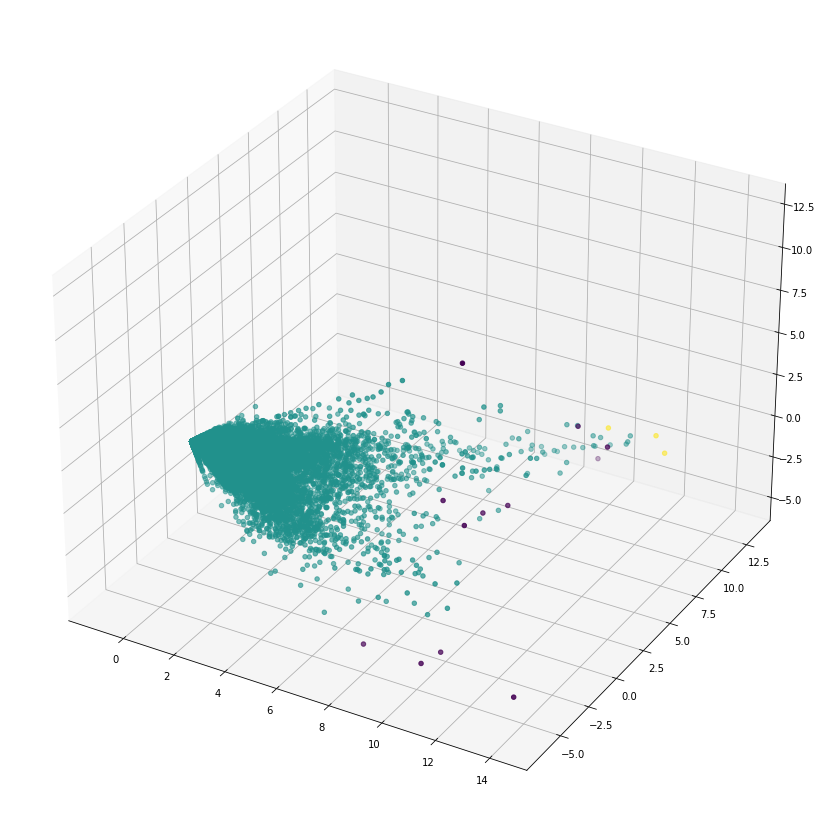

DBSCAN hyperparameters: n_components = 3, eps = 1.9, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


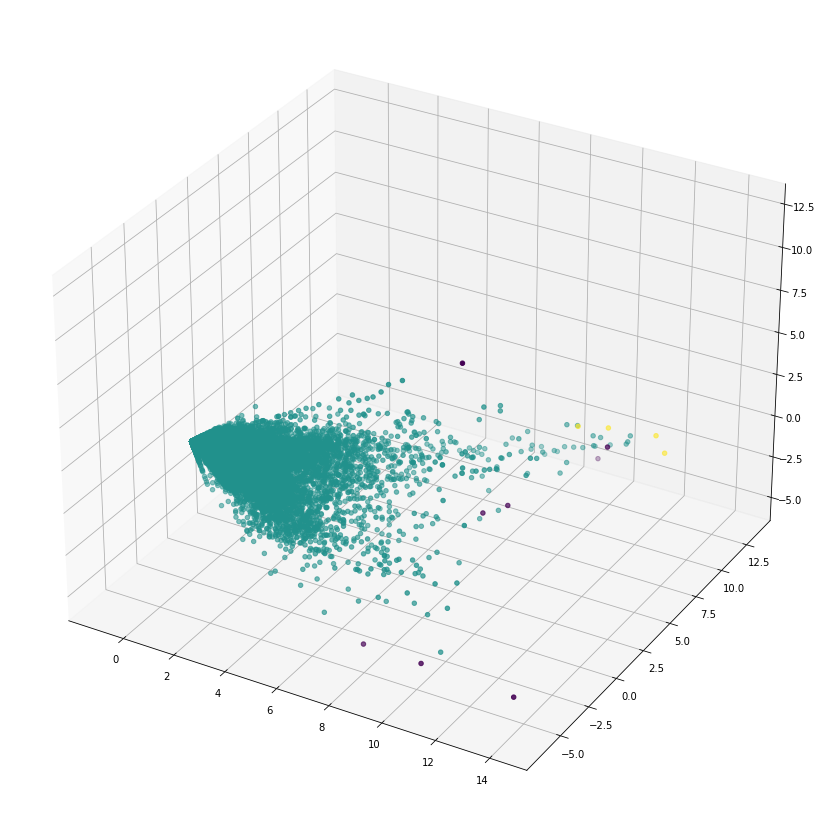

DBSCAN hyperparameters: n_components = 3, eps = 2.0, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


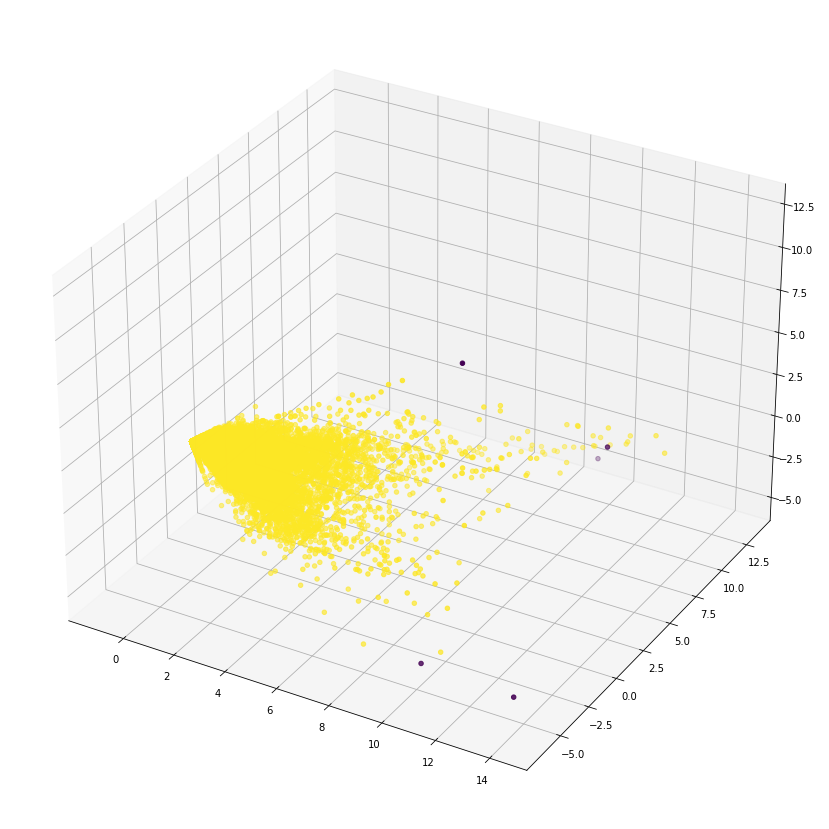

DBSCAN hyperparameters: n_components = 3, eps = 2.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


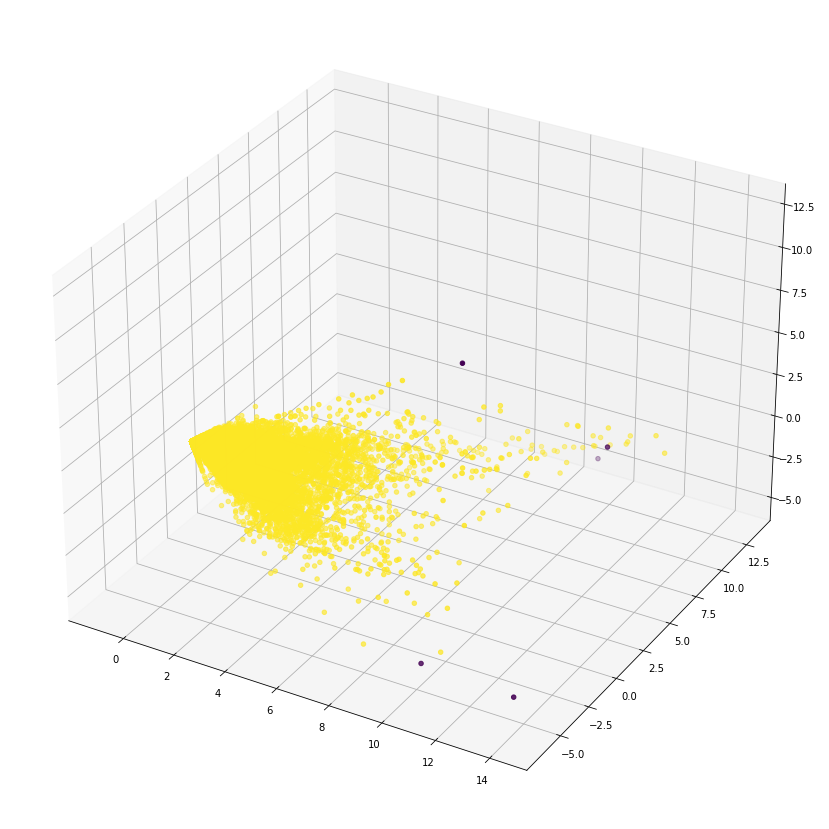

DBSCAN hyperparameters: n_components = 3, eps = 1.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


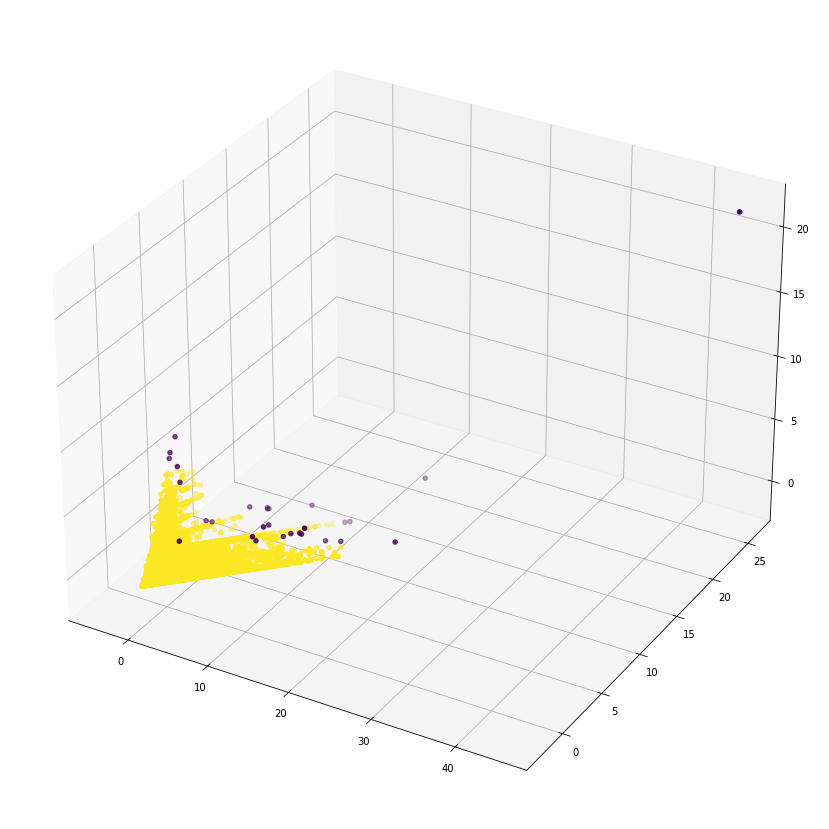

DBSCAN hyperparameters: n_components = 3, eps = 1.2, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


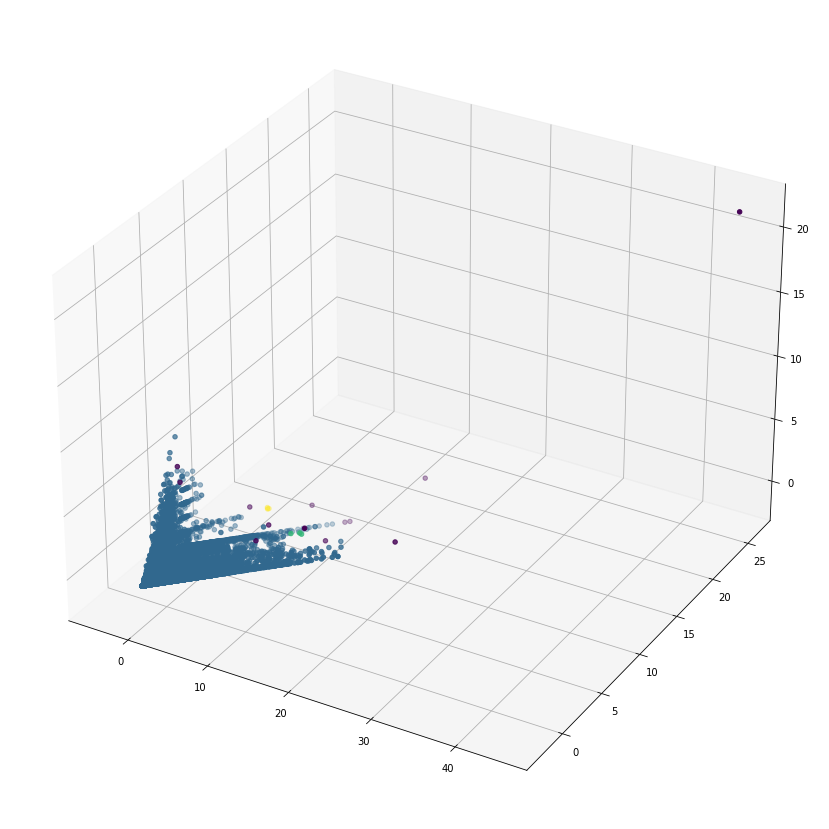

DBSCAN hyperparameters: n_components = 3, eps = 1.3, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


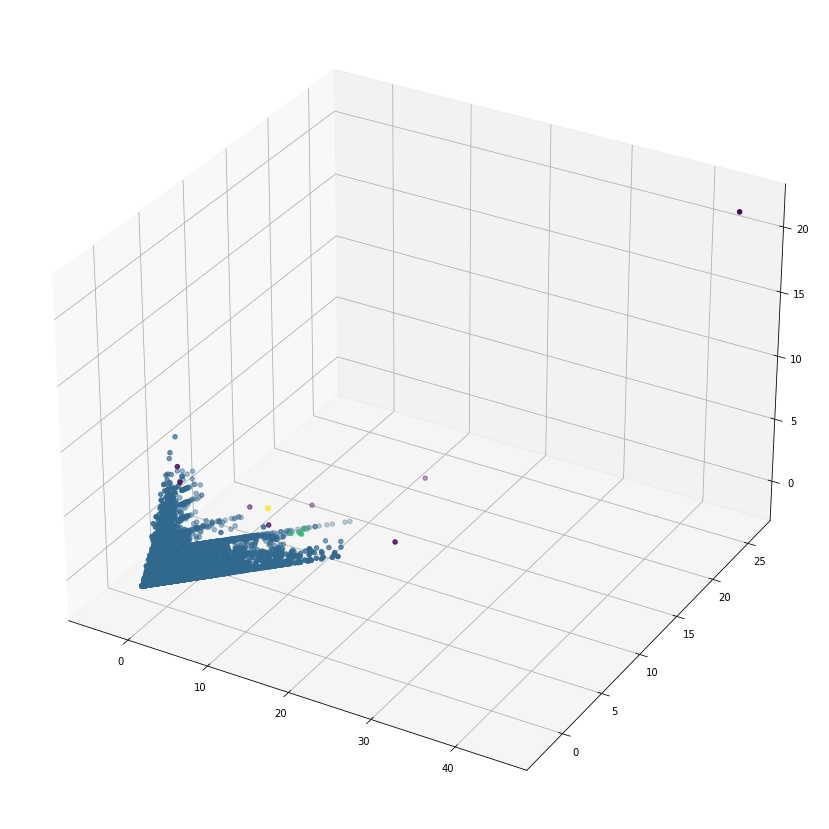

DBSCAN hyperparameters: n_components = 3, eps = 1.4, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


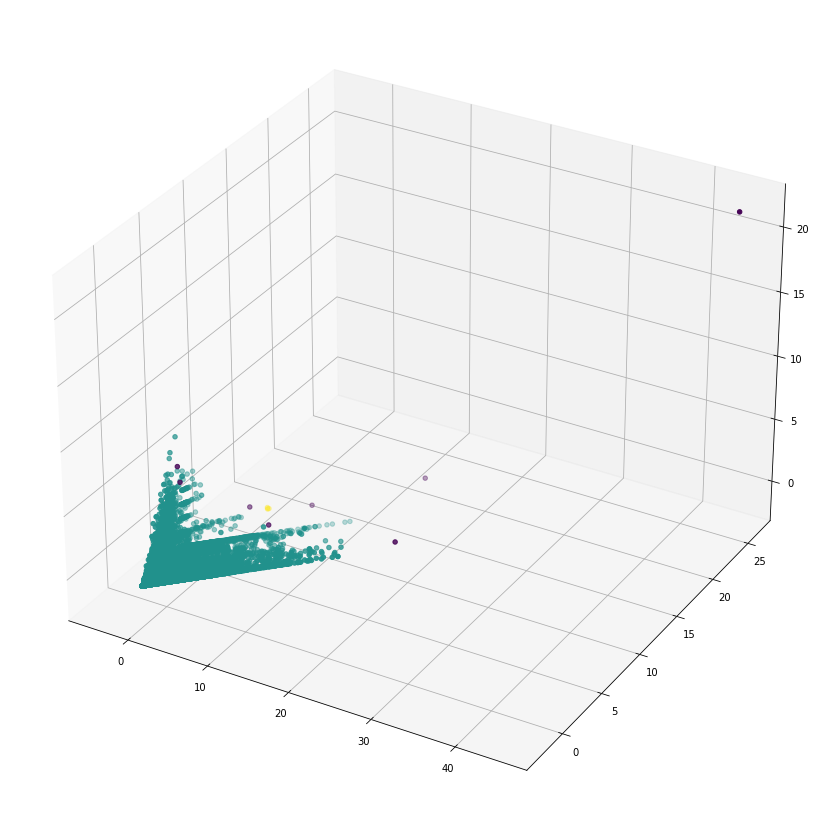

DBSCAN hyperparameters: n_components = 3, eps = 1.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


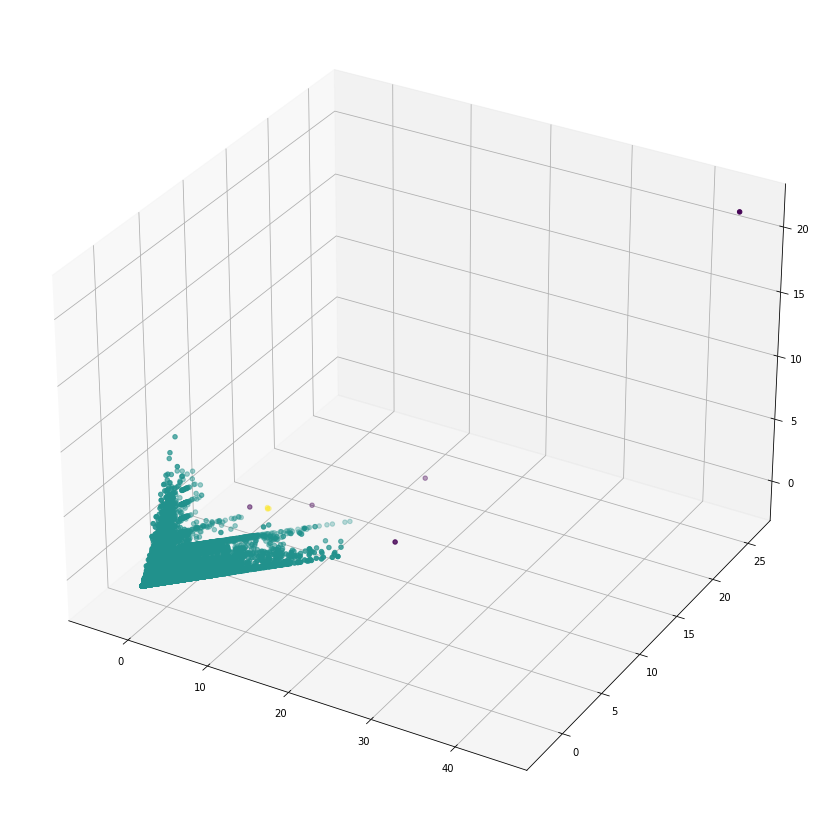

DBSCAN hyperparameters: n_components = 3, eps = 1.6, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


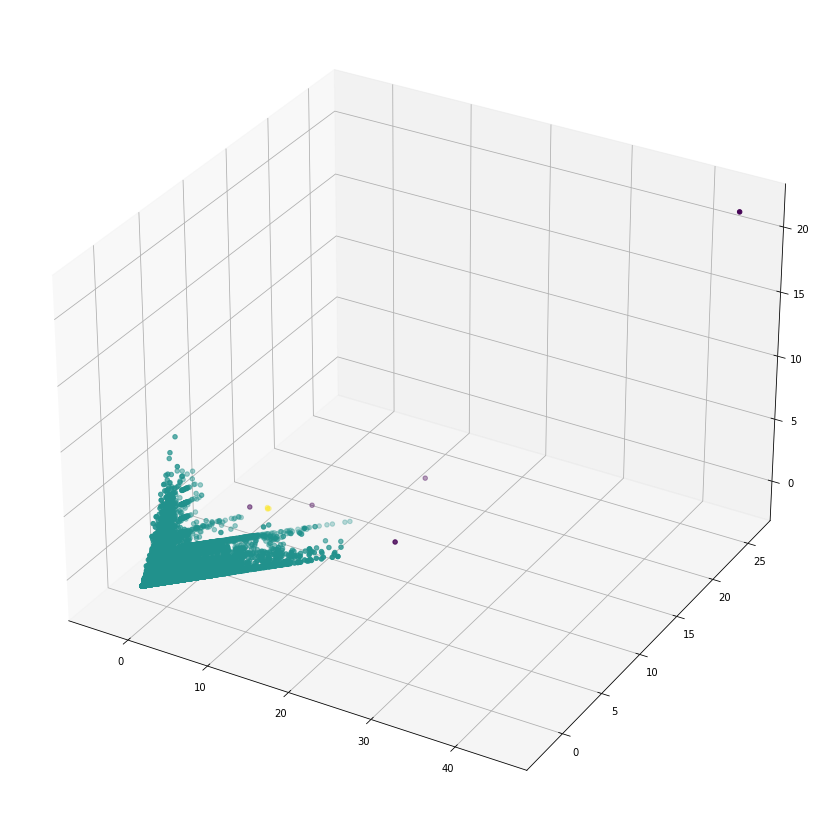

DBSCAN hyperparameters: n_components = 3, eps = 1.7, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


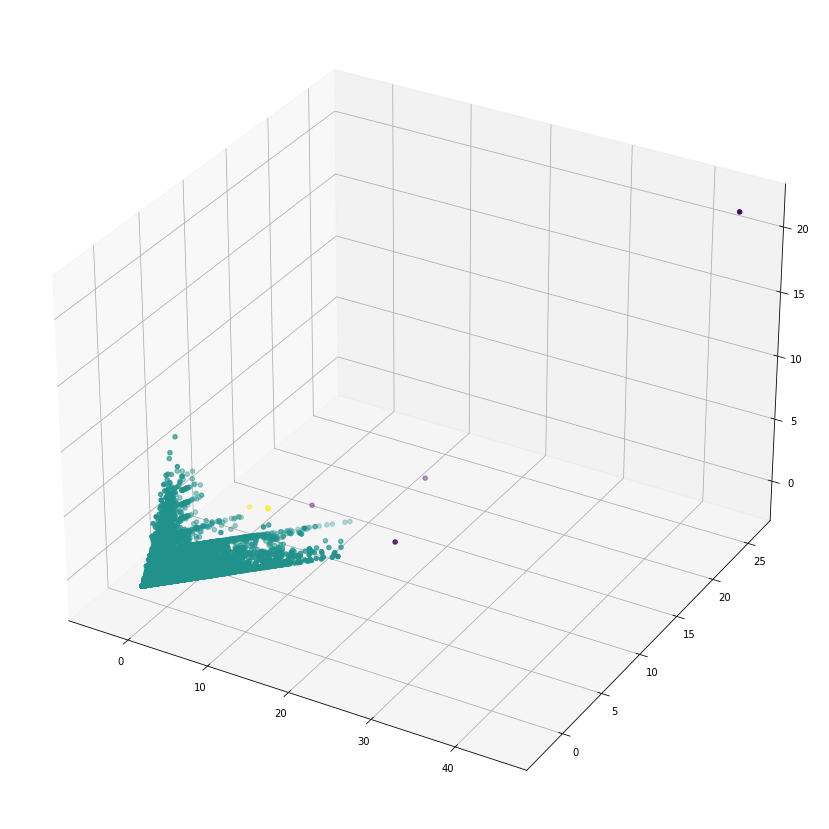

DBSCAN hyperparameters: n_components = 3, eps = 1.8, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


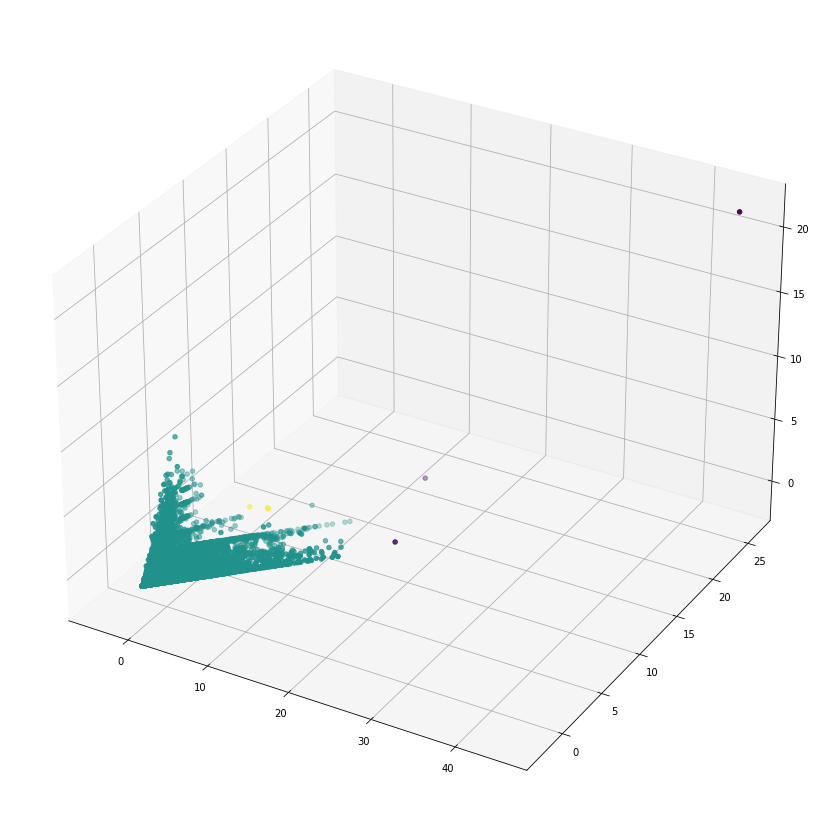

DBSCAN hyperparameters: n_components = 3, eps = 1.9, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


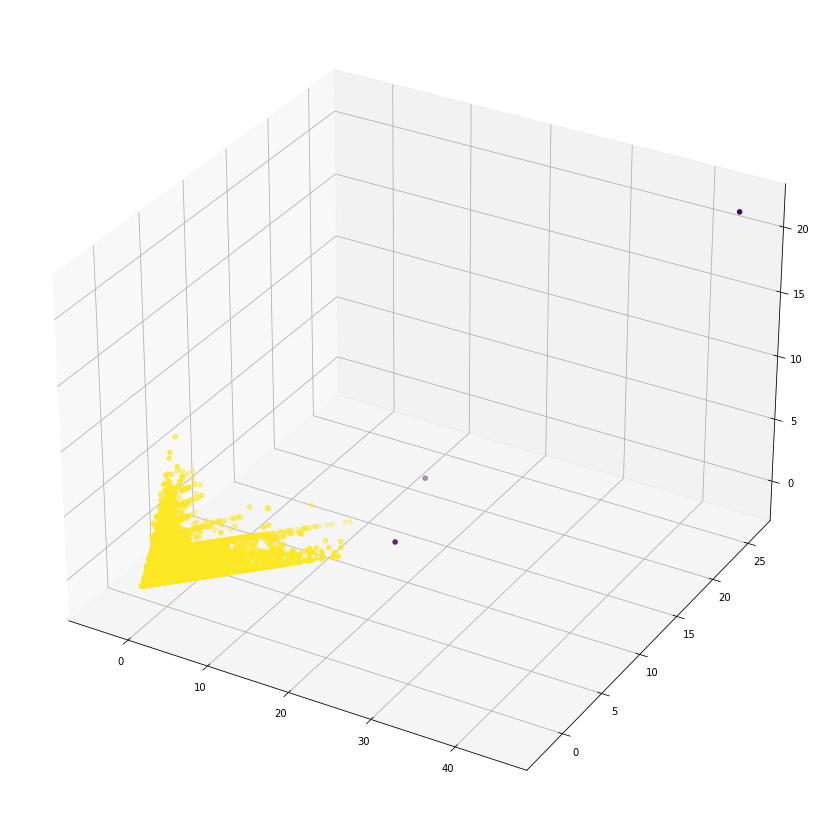

DBSCAN hyperparameters: n_components = 3, eps = 2.0, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


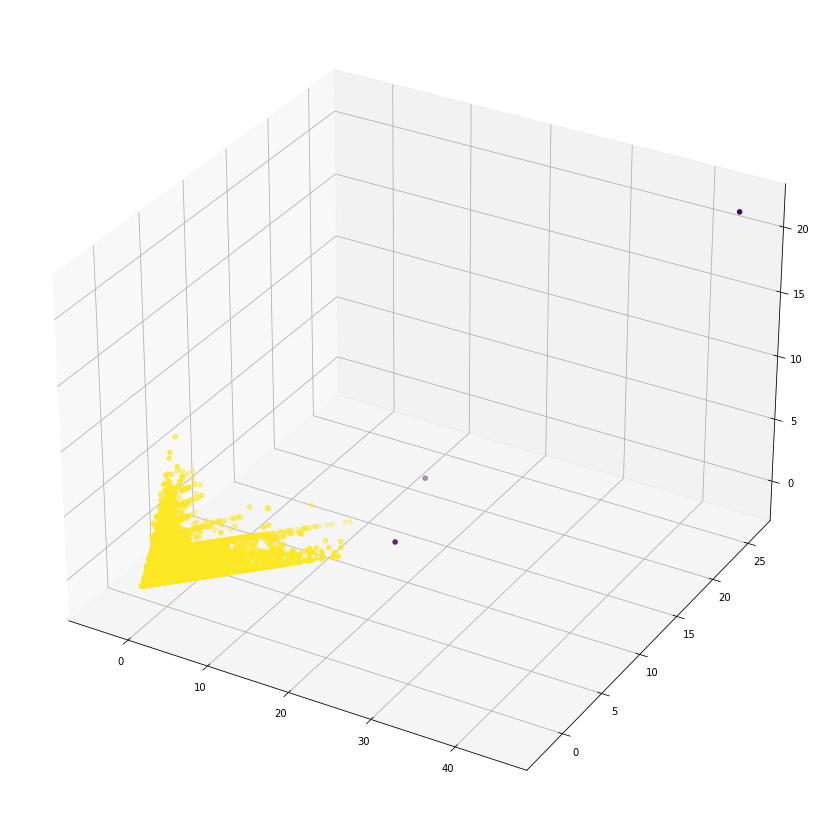

DBSCAN hyperparameters: n_components = 3, eps = 2.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


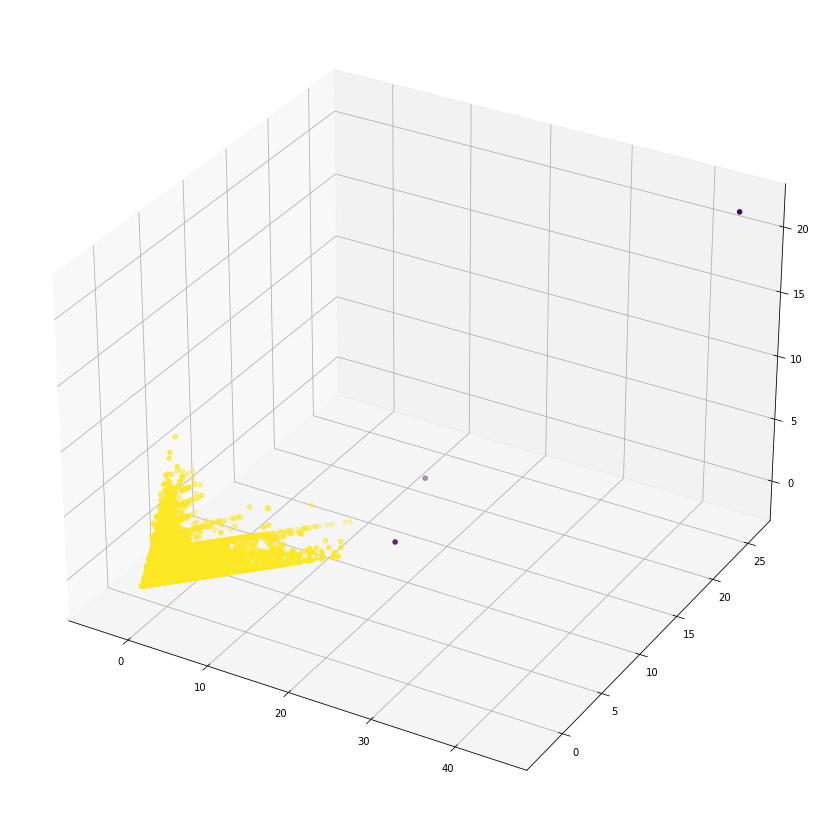

In [125]:
dbscan_evaluate(db1_main)
dbscan_evaluate(db2_main)

In [126]:
db1_grouped = db1_main.groupby(['date', 'id_ves', 'id_own', 'region']).agg({  
    'catch_volume':['sum'],
    'prod_volume':['sum'],
    'prod_board_volume':['sum']
    })

scaler = StandardScaler()
X_scale = scaler.fit_transform(db1_grouped)
pca = PCA (n_components=3)
X_reduced = pca.fit_transform(X_scale)
pred = DBSCAN(eps=1.8, min_samples=3).fit_predict(X_reduced)

db1_grouped['anomaly'] = pred

db2_grouped = db2_main.groupby(['date', 'id_ves', 'id_own', 'region']).agg({  
    'volume':['mean','median','min','max','sum'],
    'date_delta':['mean','median','min','max']
    })

scaler = StandardScaler()
X_scale = scaler.fit_transform(db2_grouped)
pca = PCA (n_components=3)
X_reduced = pca.fit_transform(X_scale)
pred = DBSCAN(eps=1.3, min_samples=3).fit_predict(X_reduced)

db2_grouped['anomaly'] = pred

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tu

Случаи со значениями anomaly, отличающимися от 0, являются аномальными и требуют рассмотрения эксперта - такие случаи представлены ниже

In [127]:
db1_grouped[db1_grouped.anomaly != 0]

catch_volume  \
                                                                       sum   
date       id_ves id_own region                                              
2022-01-13 1552   1156.0 Мавритания (ЦВА)                        1008.7380   
2022-01-22 857    1102.0 Мавритания (ЦВА)                         921.4920   
2022-01-24 761    1276.0 З.Беринг. (СЗТО)                        3346.6840   
2022-01-30 167    1102.0 Мавритания (ЦВА)                        1104.4500   
           1292   1114.0 Подзона Баренцево море (Норвегия к.)    2474.6500   
2022-02-03 1584   1219.0 Ю.Курильск. (СЗТО)                      1186.9840   
2022-03-02 1526   1050.0 Сев.Охотомор. (СЗТО)                    2697.0880   
2022-03-09 167    1102.0 Мавритания (ЦВА)                        1775.9610   
2022-03-18 167    1102.0 Мавритания (ЦВА)                        1360.6560   
2022-03-20 167    1102.0 Мавритания (ЦВА)                          92.5980   
2022-04-09 1403   1164.0 Сев.Охотомор. (СЗТО)                    5353.5825   
           1538   1091.0 Сев.Охотомор. (СЗТО)                    4927.6480   
2022-04-12 1468   951.0  Сев.Охотомор. (СЗТО)                    6242.2200   
2022-04-14 1320   989.0  Сев.Охотомор. (СЗТО)                    4504.0320   
2022-04-15 1292   1114.0 Подзона Баренцево море (Норвегия к.)    2577.4560   

                                                              prod_volume  \
                                                                      sum   
date       id_ves id_own region                                             
2022-01-13 1552   1156.0 Мавритания (ЦВА)                       672.49200   
2022-01-22 857    1102.0 Мавритания (ЦВА)                       637.95600   
2022-01-24 761    1276.0 З.Беринг. (СЗТО)                       727.13600   
2022-01-30 167    1102.0 Мавритания (ЦВА)                       662.67000   
           1292   1114.0 Подзона Баренцево море (Норвегия к.)   555.22512   
2022-02-03 1584   1219.0 Ю.Курильск. (СЗТО)                    1186.98400   
2022-03-02 1526   1050.0 Сев.Охотомор. (СЗТО)                   664.91500   
2022-03-09 167    1102.0 Мавритания (ЦВА)                       807.25500   
2022-03-18 167    1102.0 Мавритания (ЦВА)                       618.48000   
2022-03-20 167    1102.0 Мавритания (ЦВА)                        50.50800   
2022-04-09 1403   1164.0 Сев.Охотомор. (СЗТО)                   358.09400   
           1538   1091.0 Сев.Охотомор. (СЗТО)                   271.09490   
2022-04-12 1468   951.0  Сев.Охотомор. (СЗТО)                   484.13060   
2022-04-14 1320   989.0  Сев.Охотомор. (СЗТО)                   129.66500   
2022-04-15 1292   1114.0 Подзона Баренцево море (Норвегия к.)   523.24232   

                                                              prod_board_volume  \
                                                                            sum   
date       id_ves id_own region                                                   
2022-01-13 1552   1156.0 Мавритания (ЦВА)                           7250.016000   
2022-01-22 857    1102.0 Мавритания (ЦВА)                           8522.028000   
2022-01-24 761    1276.0 З.Беринг. (СЗТО)                           1876.232000   
2022-01-30 167    1102.0 Мавритания (ЦВА)                           9761.058000   
           1292   1114.0 Подзона Баренцево море (Норвегия к.)       4931.144160   
2022-02-03 1584   1219.0 Ю.Курильск. (СЗТО)                            0.000000   
2022-03-02 1526   1050.0 Сев.Охотомор. (СЗТО)                       2038.642000   
2022-03-09 167    1102.0 Мавритания (ЦВА)                           6731.265000   
2022-03-18 167    1102.0 Мавритания (ЦВА)                          10193.475000   
2022-03-20 167    1102.0 Мавритания (ЦВА)                          12912.768000   
2022-04-09 1403   1164.0 Сев.Охотомор. (СЗТО)                       1842.465800   
           1538   1091.0 Сев.Охотомор. (СЗТО)                       3284.695300   
2022-04-12 1468   951.0  

In [129]:
db2_grouped[db2_grouped.anomaly != 0]

volume                               \
                                       mean    median      min       max   
date       id_ves id_own region                                            
2021-12-31 1468   1081   \N      202.508750  238.0150   83.484   250.521   
           1473   1081   \N      210.080250  210.2185  203.820   216.064   
           1505   897    \N      320.229000  320.2290  316.955   323.503   
           1526   1050   \N      375.674500  375.6745  154.476   596.873   
2022-01-12 1473   1081   \N      180.177750  163.4595  123.771   270.021   
2022-01-24 1361   961    \N      272.628500  272.6285   19.633   525.624   
2022-01-27 1486   1001   \N      366.338000  366.3380  314.494   418.182   
2022-02-07 1526   1050   \N      254.794000  254.7940  119.756   389.832   
2022-02-11 1510   1219   \N      795.210000    3.9050    0.145  3905.000   
2022-02-12 1384   1081   \N      221.608000  221.6080   86.086   357.130   
           1473   1081   \N      225.148500  225.1485  122.289   328.008   
2022-02-20 1586   1274   \N      716.048000  716.0480  716.048   716.048   
2022-02-24 1586   1274   \N      312.857000  312.8570  312.857   312.857   
2022-03-05 1628   961    \N      213.591000  213.5910  211.591   215.591   
2022-03-07 1613   983    \N      335.610500  335.6105  333.666   337.555   
2022-03-17 1584   1219   \N      235.060000  235.0600    2.100   468.020   
2022-03-24 1568   961    \N       82.071667    0.4920    0.492   245.231   
2022-03-26 1425   1228   \N      397.388500  397.3885    4.276   790.501   
2022-04-01 1425   1228   \N      340.984500  340.9845  219.382   462.587   
2022-04-09 1538   1091   \N      615.955500  615.9555  615.955   615.956   
           1656   1091   \N      309.345000  309.3450  309.309   309.381   
2022-04-10 1556   1011   \N      214.346500  214.3465  209.864   218.829   
2022-04-13 1425   1228   \N      366.802500  366.8025  360.531   373.074   
2022-04-14 1505   897    \N      278.842500  278.8425  277.612   280.073   
2022-04-18 1613   983    \N      168.822667  173.2340   80.000   253.234   
2022-04-24 1468   951    \N      288.230000  288.2300  283.609   292.851   

                                          date_delta                anomaly  
                                      sum       mean median min max          
date       id_ves id_own region                                              
2021-12-31 1468   1081   \N       810.035   3.250000    1.0   0  11       1  
           1473   1081   \N       840.321   6.500000    6.5   2  11       1  
           1505   897    \N       640.458   4.000000    4.0   3   5      -1  
           1526   1050   \N       751.349   4.000000    4.0   4   4      -1  
2022-01-12 1473   1081   \N       720.711   1.000000    1.0   0   2       1  
2022-01-24 1361   961    \N       545.257  11.000000   11.0  11  11      -1  
2022-01-27 1486   1001   \N       732.676   7.000000    7.0   4  10      -1  
2022-02-07 1526   1050   \N       509.588   7.000000    7.0   7   7      -1  
2022-02-11 1510   1219   \N      3976.050  23.000000   23.0  23  23      -1  
2022-02-12 1384   1081   \N       443.216  23.000000   23.0  23  23      -1  
           1473   1081   \N       450.297  23.000000   23.0  23  23      -1  
2022-02-20 1586   1274   \N       716.048   4.000000    4.0   4   4      -1  
2022-02-24 1586   1274   \N       625.714   9.000000    9.0   5  13      -1  
2022-03-05 1628   961    \N       427.182  12.000000   12.0   1  23      -1  
2022-03-07 1613   983    \N       671.221  22.000000   22.0  21  23      -1  
2022-03-17 1584   1219   \N       470.120  20.000000   20.0  20  20      -1  
2022-03-24 1568   961    \N       246.215  16.333333   23.0   3  23      -1  
2022-03-26 1425   1228   \N       794.777   2.000000    2.0   2   2      -1  
2022-04-01 1425   1228   \N       681.969   7.000000    7.0   7   7      -1  
2022-04-09 1538   1091   \N      1231.911  23.000000   23.0  23  23      -1  
           1656   1091   \N       618.

In [ ]:
db1_grouped[db1_grouped.anomaly != 0].to_csv('Anomalies in db1.csv',index=None)
db2_grouped[db2_grouped.anomaly != 0].to_csv('Anomalies in db2.csv',index=None)